Data: Combined with added features , Shades and Radiation. <br>
Split: Train, Validate, Test

# 1. Import and Load

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
# parameters search
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from bayes_opt import BayesianOptimization

# models
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor
import catboost as cb
import lightgbm as lgb
# To: install catboost
# !pip3 install catboost

from datetime import datetime
import os
import pathlib
import matplotlib.pyplot as plt

In [2]:
Bldg = pd.read_csv("../Data/microclimate_model/Combined/all_buildings.csv")
Bldg = Bldg.drop(columns = ['Unnamed: 0', "Date_Time"])


# 2. EDA

## 2.1 Boxplots

In [3]:
# Create List of building names so we can extract the name easily 
BldgName = list(Bldg.bldgname.unique())

# Create list of building df to do time series plot
BldgList = []

for i in range(len(BldgName)):
    bldg_single = Bldg[Bldg['bldgname'] == BldgName[i]]
    BldgList.append(bldg_single)
    
for bldg in BldgList:
    bldg = bldg.reset_index(inplace = True, drop = True)

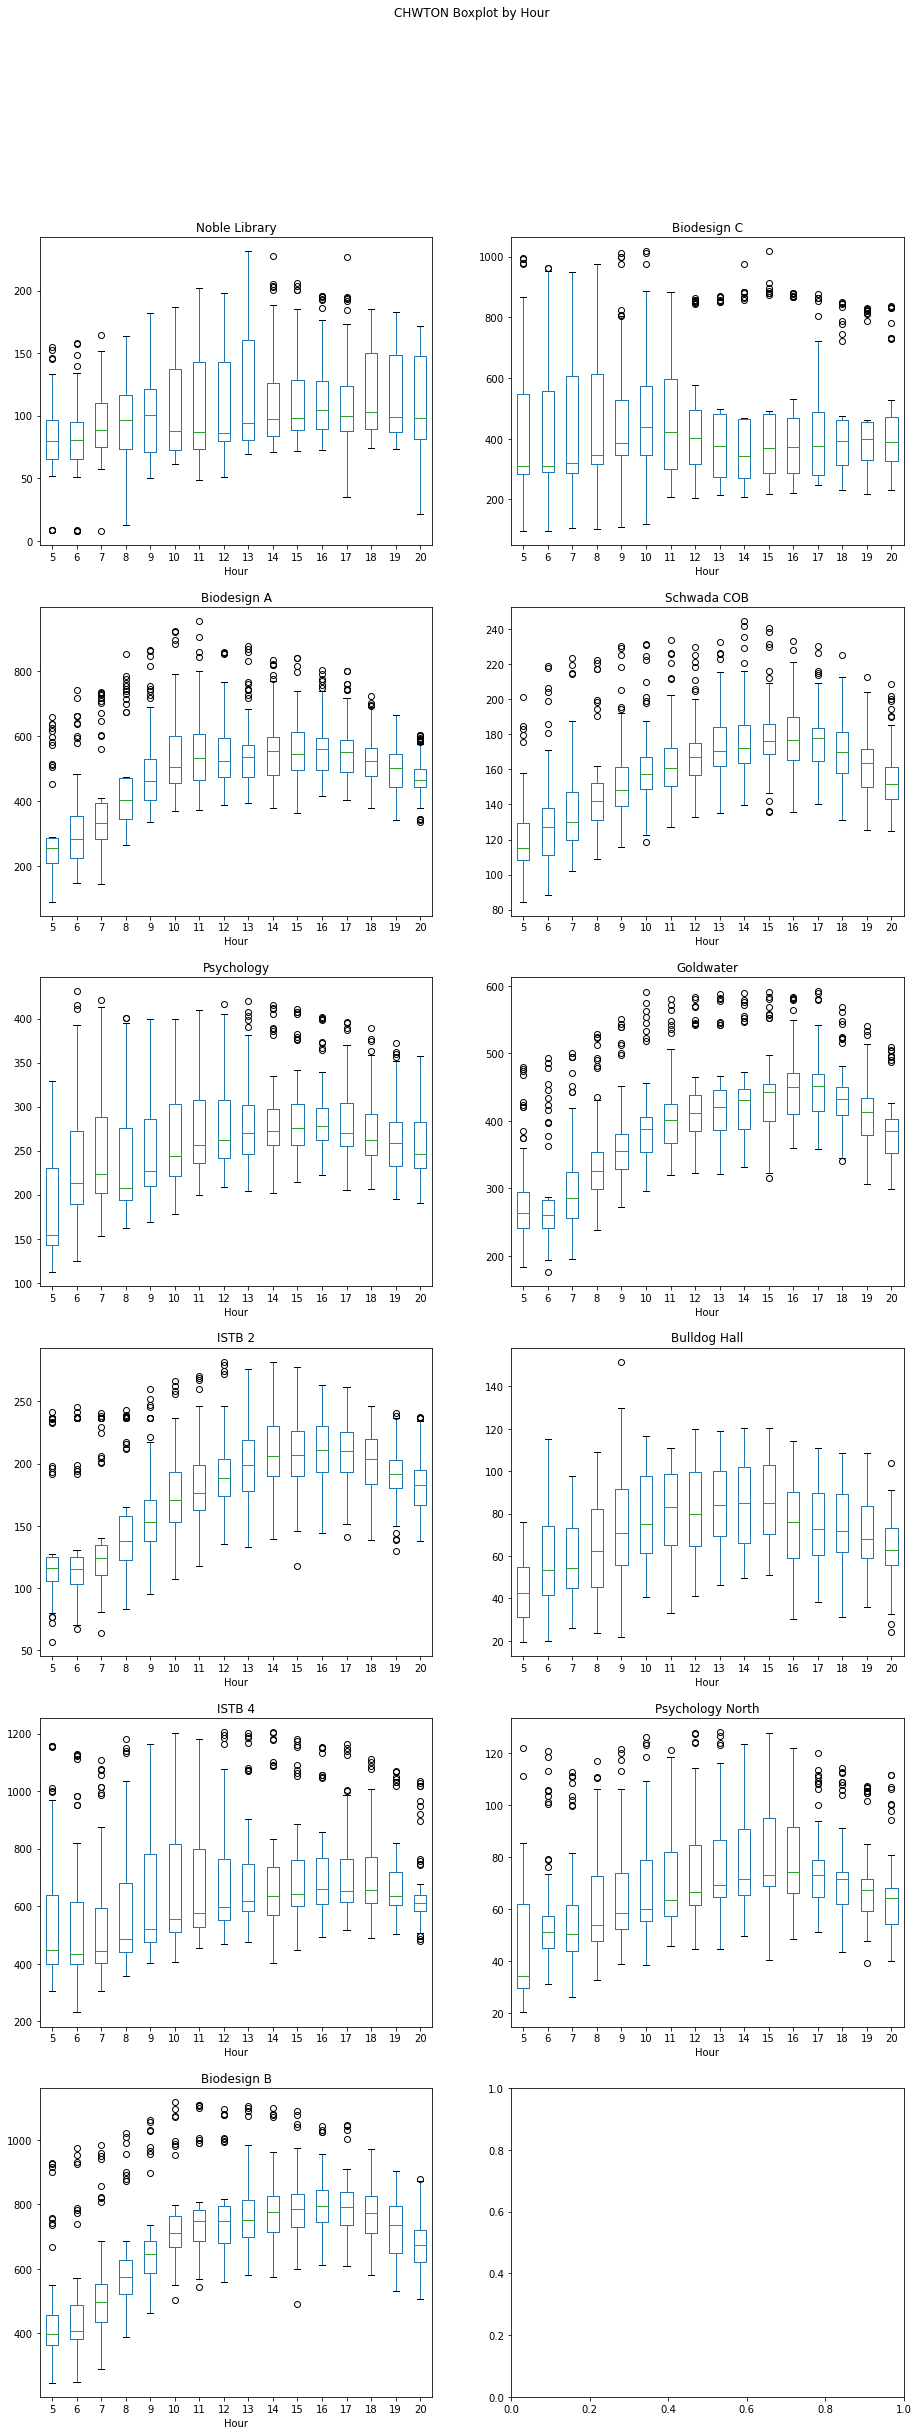

In [4]:
#Create CHWTON boxplots for all buildings #
def createBoxPlot(df, columnName, BldgName):
    row_size = 6
    column_size = 2
    fig, ax = plt.subplots(row_size, column_size, figsize = (15,40))

    i = 0
    # 1. loop through the 11 buildings
    while i < (len(BldgName)):
        # 2. Create row (6)
        for row in range(row_size):
            #4. Create column 2
            for col in range(column_size):
                if i < (len(BldgName)):
                    
                    # create boxplot of this df
                    df[i].boxplot(by='Hour',
                                    column=[columnName],
                                    grid = False,
                                    figsize = (5,5),
                                    ax = ax[row,col] )
                    ax[row,col].title.set_text(BldgName[i])
                    i += 1

    fig.suptitle(columnName + ' Boxplot by Hour')
    plt.show()
    
createBoxPlot(BldgList, 'CHWTON', BldgName)

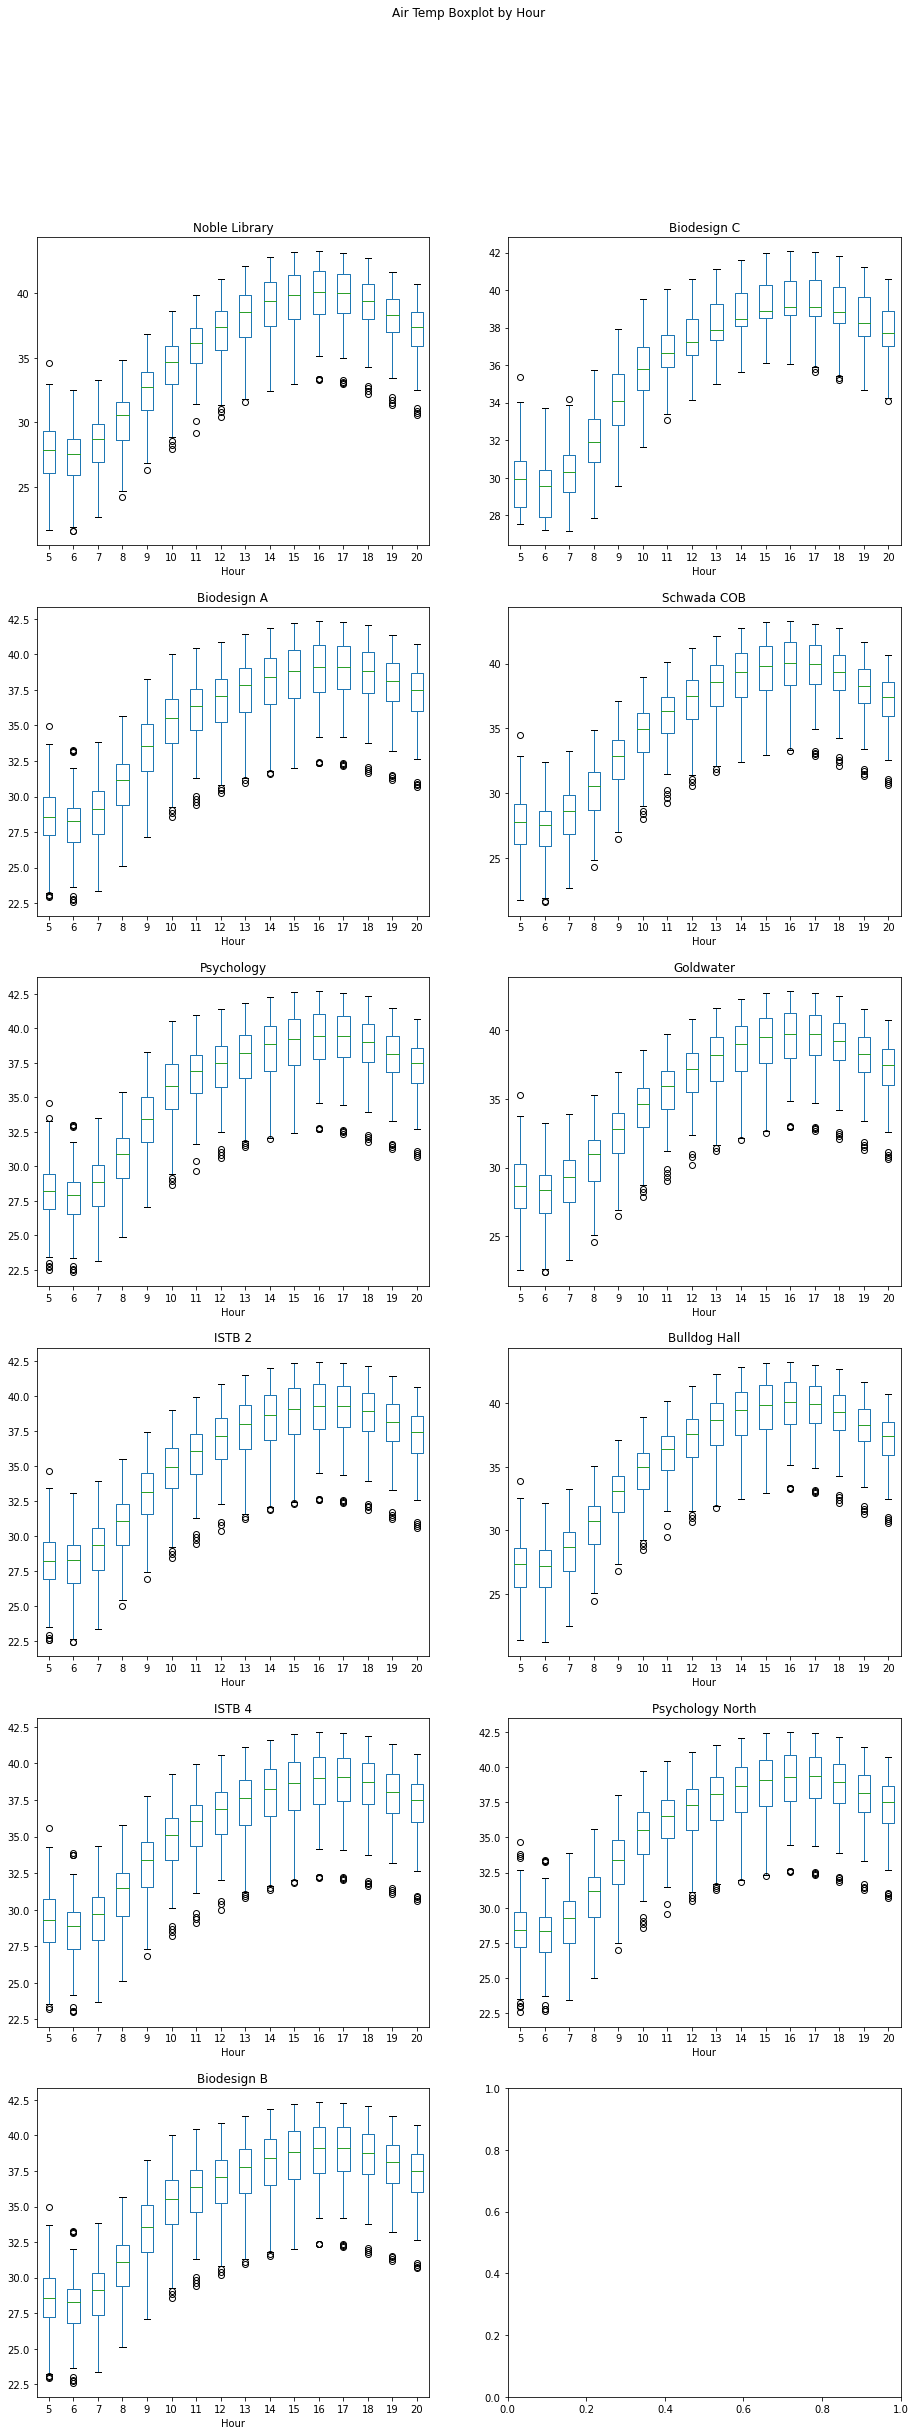

In [5]:
createBoxPlot(BldgList, 'Air Temp', BldgName)

## 2.2 Time Series

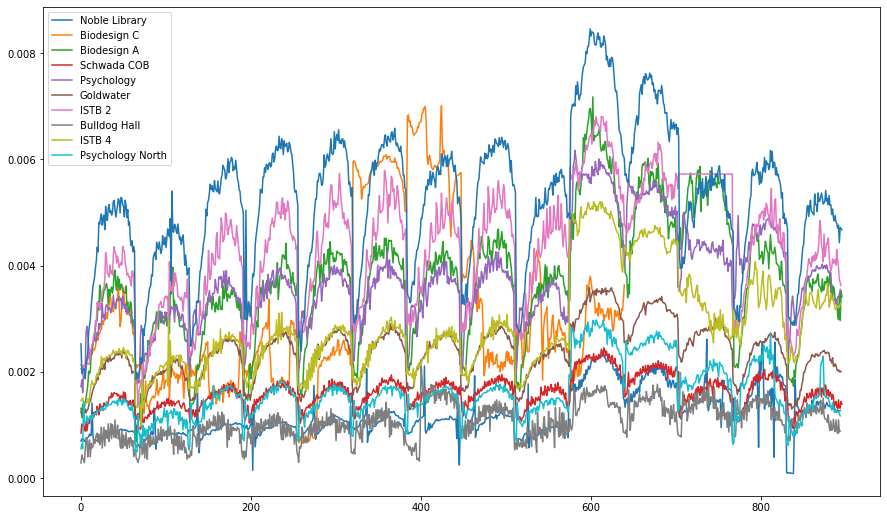

In [6]:
## Print CHWTON/SQFT for all buildings and all timestamps in data
ax = BldgList[0]['CHWTON/SQFT'].plot(figsize = (15,9))
legendlabels = []

for i in range(len(BldgList)-1):
    BldgList[i+1]['CHWTON/SQFT'].plot(ax=ax)
    legendlabels.append(BldgList[i].bldgname[0])
    
ax.legend(labels = legendlabels)


# 3. Feature Engineering

## 3.1 Remove unused column

## 3.2 One Hot encoding

In [7]:
# Integer Encode
Bldg = pd.get_dummies(Bldg, drop_first = True)

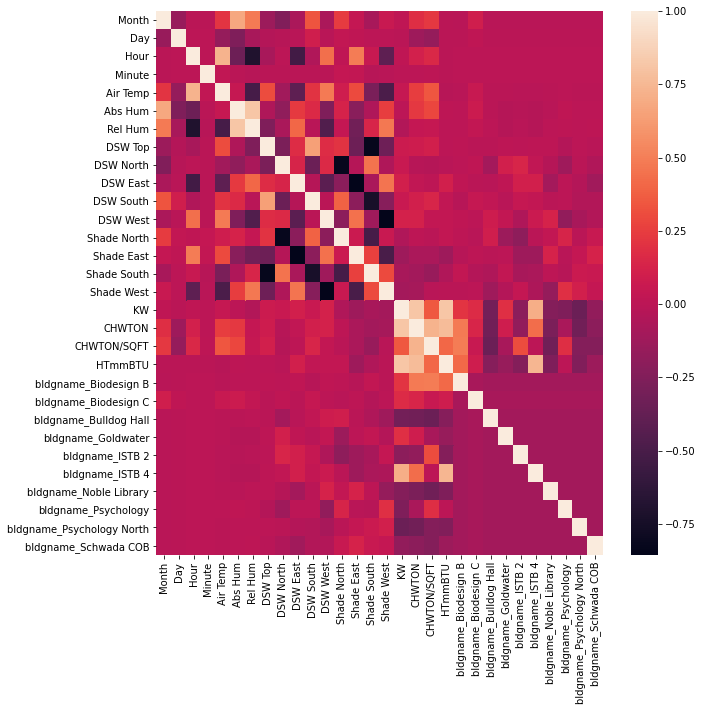

In [8]:

corrMatrix = Bldg.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corrMatrix)
plt.show()

## 3.3 Cyclic Time

In [9]:
# function to encode df columns into sine and cosine
def encode(df, col, max_val):
    df[col.replace('_num', '') + '_sin'] = np.sin(2 * np.pi * df[col]/max_val)
    df[col.replace('_num', '') + '_cos'] = np.cos(2 * np.pi * df[col]/max_val)
    df.drop(columns = [col], inplace = True)
    return df

# create a list of df for buildings with cyclical time features
Bldg_cyclic = []

Bldg_enc = Bldg.copy(deep = True)
Bldg_enc = encode(Bldg_enc, 'Minute', 60.0)
Bldg_enc = encode(Bldg_enc, 'Hour', 23.0)
Bldg_enc = encode(Bldg_enc, 'Day', 30.0)
Bldg_enc = encode(Bldg_enc, 'Month', 12.0)
Bldg_cyclic = Bldg_enc
    
# Plot cyclical features sample
# fig, ax = plt.subplots(2,2, figsize = (8,7))
# Bldg_cyclic.plot.scatter('Minute_sin', 'Minute_cos', ax = ax[0,0]).set_aspect('equal')
# Bldg_cyclic.plot.scatter('Hour_sin', 'Hour_cos', ax = ax[0,1]).set_aspect('equal')
# Bldg_cyclic.plot.scatter('Day_sin', 'Day_cos', ax = ax[1,0]).set_aspect('equal')
# Bldg_cyclic.plot.scatter('Month_sin', 'Month_cos', ax = ax[1,1]).set_aspect('equal')
Bldg_cyclic.reset_index(drop = True, inplace = True)

# 4. Modelling set up

## 4.1 Pick desired date for Test

Month available:<br>
May: 16, 23 <br>
June: 7, 8, 20, 21, 25, 26<br>
August: 3, 27<br>
September: 11, 29<br>

In [10]:
# 1. Get user to pick the day
day = (input("Pick month and day <mm dd>: "))
x,y = day.split(" ")
x = int(x)
y = int(y)

# 2. If date is unavailable ask to pick again
while (len(Bldg[(Bldg['Month'] == x) & (Bldg['Day'] == y)]) == 0):
    day = (input("Date unavailable, pick month and day <mm dd>: "))
    x,y = day.split(" ")
    x = int(x)
    y = int(y)

print("You picked month: ", x, ", day: ",y)

Pick month and day <mm dd>:  06 25


You picked month:  6 , day:  25


In [11]:
Test_df = Bldg[(Bldg['Month'] == x) & (Bldg['Day'] == y)]
Test_df.reset_index(drop = True, inplace = True)
Test_df

# Remove Test From Bldg df 
Bldg = Bldg[~((Bldg['Month'] == x) & (Bldg['Day'] == y))]

# Check if the day is still there
Bldg.Day.unique()

array([16, 23,  7,  8, 20, 21, 26,  1,  3, 27, 11, 29])

## 4.2 Scoring function

In [12]:
scores_df = pd.DataFrame()
# function to train a model and get its scores
def trainAndGetScore(pModel, pModelName, pTuningType, pDf_all_bldg, pDf_scores, pTest_df):
    # 1. drop na values if in dataframe
    if (pDf_all_bldg.isnull().values.any() == True):
        pDf_all_bldg = pDf_all_bldg.dropna()
            
    # 2. split data into X and y
    X = pDf_all_bldg.drop(columns=['CHWTON', 'CHWTON/SQFT'])
    y = pDf_all_bldg['CHWTON/SQFT']  
    
    X_test = pTest_df.drop(columns=['CHWTON', 'CHWTON/SQFT'])
    y_test = pTest_df['CHWTON/SQFT']  
    
    # 3. Train-Test Split
    X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.2, random_state=20)
        
    # 4. fit model that already has parameters
    pModel.fit(X_train, y_train)
        
    # 5. Get prediction
    y_pred = pModel.predict(X_validate)
    ModelPred = pd.DataFrame({'Actual CHWTON/SQFT':y_validate, 'Predicted CHWTON/SQFT':y_pred})
    ModelPred = ModelPred.sort_index()
    print(ModelPred)
    
    # 6. Get best params if it's a random or grid search
    if("random" in pTuningType) or ("grid" in pTuningType):
        print(pModel.best_estimator_.get_params())
        
    # 7. Get score
    scoreTrain = pModel.score(X_train, y_train)
    scoreValidate = pModel.score(X_validate, y_validate)
    scoreTest = pModel.score(X_test, y_test)
    
    # 8. Save Score
    # 8.1 Get index
    # if the model name we have is already in previous df's row , use that index
    if (len(pDf_scores) == 0):
        print(" zero length")
        i = 0
    else:
        # if the model name we have is already in previous df's row , use that index
        last_index = len(pDf_scores) - 1
        if (pDf_scores.loc[last_index,'modelName'] == pModelName):
            i = last_index
        else:
        # new model name add to new row
            i = len(pDf_scores)
            
    # 8.2 add scores to df
    pDf_scores.loc[i,'modelName'] = pModelName
    pDf_scores.loc[i,pTuningType + "Train"] = scoreTrain
    pDf_scores.loc[i,pTuningType + "Validate"] = scoreValidate
    pDf_scores.loc[i,pTuningType + "Test"] = scoreTest
    

In [13]:
Bldg_cyclic


,Air Temp,Abs Hum,Rel Hum,DSW Top,DSW North,DSW East,DSW South,DSW West,Shade North,Shade East,...,bldgname_Psychology North,bldgname_Schwada COB,Minute_sin,Minute_cos,Hour_sin,Hour_cos,Day_sin,Day_cos,Month_sin,Month_cos
0,23.516047,4.534450,21.408253,0.000000,0.000000,0.000000,0.0,0.0,1.00000,1.000000,...,0,0,0.000000e+00,1.000000e+00,0.979084,0.203456,-0.207912,-0.978148,0.5,-8.660254e-01
1,22.987733,5.423899,26.391075,0.000000,0.000000,0.000000,0.0,0.0,1.00000,1.000000,...,0,0,1.000000e+00,2.832769e-16,0.979084,0.203456,-0.207912,-0.978148,0.5,-8.660254e-01
2,22.796033,5.251924,25.836088,0.000000,0.000000,0.000000,0.0,0.0,1.00000,1.000000,...,0,0,5.665539e-16,-1.000000e+00,0.979084,0.203456,-0.207912,-0.978148,0.5,-8.660254e-01
3,22.718680,5.220844,25.797224,0.000000,0.000000,0.000000,0.0,0.0,1.00000,1.000000,...,0,0,-1.000000e+00,-1.836970e-16,0.979084,0.203456,-0.207912,-0.978148,0.5,-8.660254e-01
4,22.609159,5.195012,25.831215,12.571673,12.662661,5.287429,0.0,0.0,0.87147,0.981318,...,0,0,0.000000e+00,1.000000e+00,0.997669,-0.068242,-0.207912,-0.978148,0.5,-8.660254e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9584,34.788404,7.628841,19.487521,0.000000,0.000000,0.000000,0.0,0.0,1.00000,1.000000,...,0,0,-1.000000e+00,-1.836970e-16,-0.887885,0.460065,-0.207912,0.978148,-1.0,-1.836970e-16
9585,34.618771,7.730060,19.921645,0.000000,0.000000,0.000000,0.0,0.0,1.00000,1.000000,...,0,0,0.000000e+00,1.000000e+00,-0.730836,0.682553,-0.207912,0.978148,-1.0,-1.836970e-16
9586,34.448187,7.886578,20.506988,0.000000,0.000000,0.000000,0.0,0.0,1.00000,1.000000,...,0,0,1.000000e+00,2.832769e-16,-0.730836,0.682553,-0.207912,0.978148,-1.0,-1.836970e-16
9587,34.306344,7.940422,20.800771,0.000000,0.000000,0.000000,0.0,0.0,1.00000,1.000000,...,0,0,5.665539e-16,-1.000000e+00,-0.730836,0.682553,-0.207912,0.978148,-1.0,-1.836970e-16


# 5. Model 1: Random Forest


## 5.1 No Tuning

In [14]:
RF_base = RandomForestRegressor(n_estimators = 100, random_state = 42)

# 1. Base RF on base data
trainAndGetScore(RF_base, "RF", "base", Bldg, scores_df, Test_df)

# 2. Base RF on cyclical time features
# trainAndGetScore(RF_base, "RF_cyclic", "base", Bldg_cyclic, scores_df, Test_cyclic_df)



      Actual CHWTON/SQFT  Predicted CHWTON/SQFT
3               0.000741               0.000721
12              0.000809               0.000928
18              0.000712               0.000769
37              0.000834               0.000831
38              0.000836               0.000843
...                  ...                    ...
9556            0.005345               0.005107
9562            0.005212               0.005223
9567            0.005179               0.005387
9570            0.005210               0.005244
9576            0.004960               0.004943

[1777 rows x 2 columns]
 zero length


In [15]:
scores_df

,modelName,baseTrain,baseValidate,baseTest
0,RF,0.998677,0.988985,0.955941


## 5.2 Random Search Tuning

In [16]:
# Define parameters for RF

# 1. Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]

# 2. Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# 3. Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# 4. Minimum number of samples required at each leaf node
min_samples_leaf = [ 1, 2, 4]

# 5. Method of selecting samples for training each tree
bootstrap = [True, False]

# 6. Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [17]:
# 1. Set parameters on random_RF
RF_random = RandomizedSearchCV(estimator = RF_base,
                               param_distributions = random_grid,
                               n_iter = 20, cv = 5,
                               verbose = 2,
                               scoring ='r2',
                               random_state = 42,
                               n_jobs = -1)

# 2. Train on base data
trainAndGetScore(RF_random, "RF", "random", Bldg, scores_df, Test_df)

# 3. Train on data with cyclical time features
# trainAndGetScore(RF_random, "RF_cyclic", "random", Bldg_cyclic, scores_df)
scores_df

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.3min finished


      Actual CHWTON/SQFT  Predicted CHWTON/SQFT
3               0.000741               0.000728
12              0.000809               0.000934
18              0.000712               0.000755
37              0.000834               0.000841
38              0.000836               0.000853
...                  ...                    ...
9556            0.005345               0.005009
9562            0.005212               0.005261
9567            0.005179               0.005285
9570            0.005210               0.005304
9576            0.004960               0.005075

[1777 rows x 2 columns]
{'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 20, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


,modelName,baseTrain,baseValidate,baseTest,randomTrain,randomValidate,randomTest
0,RF,0.998677,0.988985,0.955941,0.999939,0.989258,0.958264


In [18]:
print(RF_random.best_estimator_.get_params())

{'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 20, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [19]:
scores_df

,modelName,baseTrain,baseValidate,baseTest,randomTrain,randomValidate,randomTest
0,RF,0.998677,0.988985,0.955941,0.999939,0.989258,0.958264


## 5.3. Grid Search Tuning

In [ ]:
param_grid = {'n_estimators': [200, 220, 230,240],
               'max_features': ["sqrt"],
               'max_depth': [17, 20, 22],
               'min_samples_split': [2,3,4],
               'min_samples_leaf': [ 1, 2],
               'bootstrap': bootstrap}

In [ ]:
# 1. Set parameters on random_RF
RF_grid = GridSearchCV(estimator = RF_base,
                       param_grid = param_grid,
                       cv = 5,
                       scoring ='r2',
                       n_jobs = -1)

# 2. Train on base data
trainAndGetScore(RF_grid, "RF", "grid", Bldg_df, scores_df)

# 3. Train on data with cyclical time features
# trainAndGetScore(RF_grid, "RF_grid_cyclic", Bldg_cyclic, scores_df)
scores_df

# 6. Model 2: XGBoost

## 6.1 No Tuning

In [ ]:
# 1. create base model
XGB_base = XGBRegressor(n_estimators = 100, random_state = 42)

# 2. Base XGB on base data
trainAndGetScore(XGB_base, "XGB_base", Bldg, scores_df)

# 3. Base XGB on cyclica time features
trainAndGetScore(XGB_base, "XGB_cyclic", Bldg_cyclic, scores_df)
scores_df

## 6.2 Random Search Tuning

In [ ]:
# 1. Define grid
params = {
    'n_estimators':[ 100, 250, 500, 1000],
    'min_child_weight':[4,5,8], 
    'gamma':[i/10.0 for i in range(3,6)],  
    'subsample':[i/10.0 for i in range(6,11)],
    'colsample_bytree':[i/10.0 for i in range(6,11)], 
    'max_depth': [2,3,4,6,7],
    'objective': ['reg:squarederror', 'reg:tweedie'],
    'booster': ['gbtree', 'gblinear'],
    'eval_metric': ['rmse'],
    'eta': [i/10.0 for i in range(3,6)],
}

# 2. Set up model with grid
n_iter_search = 20
XGB_random = RandomizedSearchCV(XGB_base,
                                param_distributions = params,
                                n_iter = n_iter_search,
                                cv = 5,
                                verbose = 2,
                                random_state = 42,
                                scoring ='r2',
                                n_jobs = -1)

# 2. Train on base data
trainAndGetScore(XGB_random, "XGB_random", Bldg, scores_df)

# 3. Train on data with cyclical time features
trainAndGetScore(XGB_random, "XGB_random_cyclic", Bldg_cyclic, scores_df)
scores_df

# 7. Model 3: LightGBM

## 7.1 No Tuning

In [ ]:
LGBM_base = lgb.LGBMRegressor(random_state = 42)

# 2. Base LGBM on base data
trainAndGetScore(LGBM_base, "LGBM_base", Bldg, scores_df)

# 3. Base LGBM on cyclica time features
trainAndGetScore(LGBM_base, "LGBM_cylic", Bldg_cyclic, scores_df)
scores_df

## 7.2 Random Search Tuning

In [ ]:
# 1. Define grid
random_grid = {
    'num_leaves': [7, 14, 21, 28, 31, 50],
    'learning_rate': [0.1, 0.03, 0.003],
    'max_depth': [-1, 3, 5],
    'n_estimators': [50, 100, 200, 500],
}

# 2. Set up model with grid
LGBM_random = RandomizedSearchCV(estimator = LGBM_base,
                                 param_distributions = random_grid, 
                                 n_iter = 100, cv = 2,
                                 scoring='r2',
                                 verbose= 2,
                                 random_state= 42,
                                 n_jobs = -1)


In [ ]:
# 3. Base LGBM on base data
trainAndGetScore(LGBM_random, "LGBM_random", Bldg, scores_df)

# 4. Base LGBM on cyclica time features
trainAndGetScore(LGBM_random, "LGBM_random_cyclic", Bldg_cyclic, scores_df)
scores_df

In [ ]:
print("ONE HOT ENCODING SCORE:")
scores_df

# 8. Model 4: Catboost

## 8.1 Prepare datas using label encoder

In [ ]:
Bldg_df_cat = pd.DataFrame()
for i in range(len(Bldg)):
    Bldg_df_cat = Bldg_df_cat.append(Bldg[i])
    
Bldg_df_cat.reset_index(drop = True , inplace = True)
Bldg_df_cat.drop(columns=['Date', 'Time', 'Date_Time'],inplace = True)
# create a list of df for buildings with cyclical time features
Bldg_cyclic_cat = []

Bldg_enc = Bldg_df_cat.copy(deep = True)
Bldg_enc = encode(Bldg_enc, 'Minute_num', 60.0)
Bldg_enc = encode(Bldg_enc, 'Hour_num', 23.0)
Bldg_enc = encode(Bldg_enc, 'Day_num', 30.0)
Bldg_enc = encode(Bldg_enc, 'Month_num', 12.0)
Bldg_cyclic_cat = Bldg_enc
    
# Plot cyclical features sample
fig, ax = plt.subplots(2,2, figsize = (8,7))
Bldg_cyclic_cat.plot.scatter('Minute_sin', 'Minute_cos', ax = ax[0,0]).set_aspect('equal')
Bldg_cyclic_cat.plot.scatter('Hour_sin', 'Hour_cos', ax = ax[0,1]).set_aspect('equal')
Bldg_cyclic_cat.plot.scatter('Day_sin', 'Day_cos', ax = ax[1,0]).set_aspect('equal')
Bldg_cyclic_cat.plot.scatter('Month_sin', 'Month_cos', ax = ax[1,1]).set_aspect('equal')


In [ ]:
Bldg_cyclic_cat

In [ ]:
label_encoder = LabelEncoder()
# Assigning numerical values and storing in another column
Bldg_df_cat['bldgname'] = label_encoder.fit_transform(Bldg_df_cat['bldgname'])
Bldg_df_cat

In [ ]:
Bldg_df_cat.bldgname.unique()

In [ ]:
# 1. split data into X and y
X = Bldg_df_cat.drop(columns=['CHWTON', 'CHWTON/SQFT'])
y = Bldg_df_cat['CHWTON/SQFT']   

# 2. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)
        


## 8.2 Catboost Random Search

In [ ]:
# 1. hyperparameter grid
cb_grid = {'iterations': [50, 100, 150, 200, 250],
            'learning_rate': [0.03, 0.1],
            'depth': [2, 4, 8, 10, 12],
            'l2_leaf_reg': [0.2, 0.5, 1, 3, 5, 7]}

# 2. instantiate RandomSearchCv object
CB_random_obj = RandomizedSearchCV(estimator = catboost,
                               param_distributions = cb_grid,
                               n_iter = 20, cv = 5,
                               verbose = 2,
                               scoring ='r2',
                               random_state = 42,
                               n_jobs = -1)


# 3. Fit the model
CB_random_obj.fit(X_train,y_train)

# 4. print winning set of hyperparameters
from pprint import pprint
pprint(CB_random_obj.best_estimator_.get_params())
pprint(CB_random_obj.best_score_)

# 5. get the best model
CB_random = CB_random_obj.best_estimator_

# 6. get score 
score = CB_random.score(X_test, y_test)
scores_df['CB_random']=score
print(score)
  

In [ ]:
scores_df

## 8.3 Catboost Grid Search

In [ ]:
# 3. initialize model and grid
catboost = cb.CatBoostRegressor(loss_function='RMSE')
grid = {'depth': [8, 10,12],
        'iterations': [230,250,270],
        'learning_rate': [0.08, 0.1, 0.15],
        'l2_leaf_reg': [0.8, 1, 2]}


# 4. search parameter
train_dataset = cb.Pool(X_train, y_train) 
test_dataset = cb.Pool(X_test, y_test)
result = catboost.grid_search(grid,
                           train_dataset,
                           cv = 5,
                           search_by_train_test_split=True,
                           shuffle = True,
                           refit = True,
                           verbose = True,
                           train_size = 0.8 )


# 4. get best params
best_params = result['params']

# 5. fit model with best params
CB_grid = cb.CatBoostRegressor(depth = best_params['depth'],
                               iterations = best_params['iterations'],
                               learning_rate= best_params['learning_rate'],
                               l2_leaf_reg = best_params['l2_leaf_reg'])
CB_grid.fit(train_dataset)

# 6. get score 
score = CB_grid.score(X_test, y_test)
scores_df['CB_grid']=score
print(score)


In [ ]:
scores_df